In [16]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import cifar10

sns.set(style='white', context='notebook', palette='deep')

# Data preparation

In [2]:
train = pd.read_csv("cifar-10/trainLabels.csv")

In [3]:
train.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [4]:
X = train["id"]
Y = train["label"]
print("Training samples {}".format(X.shape))
print("Training labels {}".format(X.shape))

Training samples (50000,)
Training labels (50000,)


ship          5000
truck         5000
deer          5000
dog           5000
airplane      5000
frog          5000
horse         5000
cat           5000
bird          5000
automobile    5000
Name: label, dtype: int64

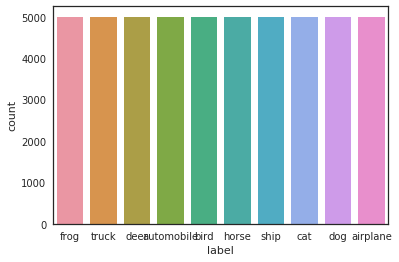

In [5]:
g = sns.countplot(Y_train)
Y_train.value_counts()

In [62]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')

In [63]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


## Label encoding

In [64]:
Y_train = to_categorical(y_train.reshape(-1, 1), num_classes = 10)
Y_test = to_categorical(y_test.reshape(-1, 1), num_classes = 10)
print("Training Labels: {}".format(Y_train.shape))
print("Testing Labels: {}".format(Y_test.shape))

Training Labels: (50000, 10)
Testing Labels: (10000, 10)


## Split training and valdiation set

In [65]:
# Set the random seed
random_seed = 2

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.3, random_state=random_seed)

In [66]:
print("Training images: {}".format(X_train.shape))
print("Training labels: {}".format(Y_train.shape))
print("Validation images: {}".format(X_val.shape))
print("Validation labels: {}".format(Y_val.shape))
print("Testing images: {}".format(X_test.shape))
print("Testing labels: {}".format(Y_test.shape))

Training images: (35000, 32, 32, 3)
Training labels: (35000, 10)
Validation images: (15000, 32, 32, 3)
Validation labels: (15000, 10)
Testing images: (10000, 32, 32, 3)
Testing labels: (10000, 10)


## Examples

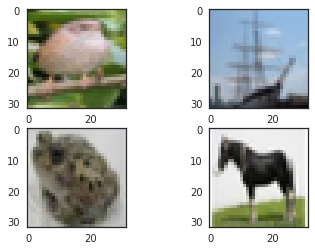

In [67]:
# Some examples
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X_train[0]/ 255.0)
axarr[0,1].imshow(X_train[1]/ 255.0)
axarr[1,0].imshow(X_train[2]/ 255.0)
axarr[1,1].imshow(X_train[3]/ 255.0)

## CNN

In [68]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [69]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [70]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [71]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [83]:
epochs = 10 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 64

In [73]:
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

In [78]:
X_t = []
for img in X_train:
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    resized_image = cv2.resize(img_bgr, (28, 28)) 
    img_gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    X_t.append(img_gray.reshape(28,28,1))
X_t = np.array(X_t)
X_v = []
for img in X_val:
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    resized_image = cv2.resize(img_bgr, (28, 28)) 
    img_gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    X_v.append(img_gray.reshape(28,28,1))
X_v = np.array(X_v)

In [84]:
print(X_v.shape)
print(X_t.shape)

(15000, 28, 28, 1)
(35000, 28, 28, 1)


In [85]:
history = model.fit_generator(datagen_train.flow(X_t,Y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = datagen_val.flow(X_v, Y_val, batch_size=batch_size),
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_steps = X_val.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/10
546/546 [==============================] - 92s 169ms/step - loss: 1.3316 - acc: 0.5345 - val_loss: 1.3628 - val_acc: 0.5242
Epoch 2/10
546/546 [==============================] - 92s 168ms/step - loss: 1.2553 - acc: 0.5631 - val_loss: 1.2008 - val_acc: 0.5804
Epoch 3/10
546/546 [==============================] - 92s 168ms/step - loss: 1.1890 - acc: 0.5879 - val_loss: 1.0632 - val_acc: 0.6364
Epoch 4/10
546/546 [==============================] - 93s 171ms/step - loss: 1.1551 - acc: 0.6031 - val_loss: 1.0713 - val_acc: 0.6305
Epoch 5/10
546/546 [==============================] - 93s 171ms/step - loss: 1.1242 - acc: 0.6116 - val_loss: 1.0603 - val_acc: 0.6327
Epoch 6/10
546/546 [==============================] - 96s 175ms/step - loss: 1.1068 - acc: 0.6265 - val_loss: 1.0495 - val_acc: 0.6395
Epoch 7/10
546/546 [==============================] - 98s 180ms/step - loss: 1.0988 - acc: 0.6273 - val_loss: 1.0587 - val_acc: 0.6339
Epoch 8/10
546/546 [==============================] - 9

# Metrics

## Training and Validation plots

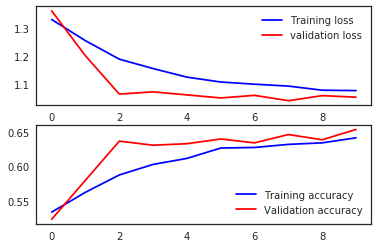

In [87]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Confusion Matrix

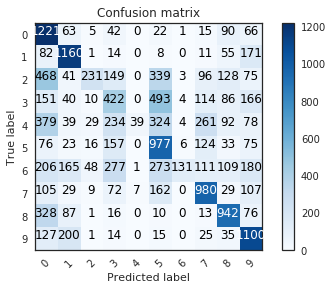

In [89]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_v)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Accuracy, recalll, presition and F1

In [90]:
print("Accuracy: {}".format(accuracy_score(Y_true, Y_pred_classes)))
print("Recall: {}".format(recall_score(Y_true, Y_pred_classes, average=None)))
print("Precision: {}".format(precision_score(Y_true, Y_pred_classes, average=None)))
print("F1: {}".format(f1_score(Y_true, Y_pred_classes, average=None)))

Accuracy: 0.4802
Recall: [ 0.80065574  0.7723036   0.15098039  0.28398385  0.02636917  0.65702757
  0.08727515  0.65333333  0.6395112   0.72511536]
Precision: [ 0.38848234  0.62804548  0.65811966  0.30207588  0.82978723  0.37247427
  0.87919463  0.56        0.5891182   0.52531041]
F1: [ 0.52313625  0.6927441   0.24561404  0.29275061  0.05111402  0.47542579
  0.15878788  0.60307692  0.61328125  0.60924952]


# Fine-Tunning

In [17]:
# Read the training labels
train = pd.read_csv("cifar-10/trainLabels.csv")
print(train.head())
X = train["id"]
Y = train["label"]
print("Training samples {}".format(X.shape))
print("Training labels {}".format(X.shape))

   id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile
Training samples (50000,)
Training labels (50000,)


In [18]:
# Set the random seed
random_seed = 2

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3, random_state=random_seed)

Counter({'airplane': 3475,
         'automobile': 3498,
         'bird': 3470,
         'cat': 3514,
         'deer': 3521,
         'dog': 3513,
         'frog': 3499,
         'horse': 3500,
         'ship': 3527,
         'truck': 3483})

In [19]:
for id_, label in zip(X_train,Y_train):
    os.makedirs("cifar-10/train-cat/"+label, exist_ok=True)
    os.system("cp cifar-10/train/"+ str(id_)+ ".png cifar-10/train-cat/"+label)
print("###########")
for id_, label in zip(X_val,Y_val):
    os.makedirs("cifar-10/val-cat/"+label, exist_ok=True)
    os.system("cp cifar-10/train/"+ str(id_)+ ".png cifar-10/val-cat/"+label)


###########
